# Exploration et filtre des données

L'objectif de ce notebook est de trouver les décisions qui correspondent à ce que l'on cherche. 

A savoir : des décisions qui concernent un recours par une entreprise ou un particulier contre une majoration de ses impôts.

Plusieurs types de majorations peuvent exister :

- 40% : manquement délibéré (mauvaise foi du contribuable)
- 80% : abus de droit (tu fais un montage pour payer moins d’impôt)
- 100% : opposition à contrôle fiscal


In [41]:
! pip install -q tqdm

You should consider upgrading via the '/Users/basiledesjuzeur/Documents/legal_analysis/venv_legal/bin/python3 -m pip install --upgrade pip' command.


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import numpy as np
import os

## Lecture d'un fichier test pour comprendre son agencement

- 19LY01259, décharge du contribuable

In [43]:
df = pd.read_csv("../data/intermediate_data.csv")

/var/folders/lt/7s5dvrb13ll759vbj0xtstr40000gp/T/ipykernel_6275/3847362736.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/intermediate_data.csv')


In [44]:
path = df[df.id == "21MA02603"]["path"].values[0]

# open file in vs code
os.system(f"code {path}")

0

## On cherche des mots clés pour discriminer les différentes majorations 

On est très conservateurs sur les règles.

In [45]:
mots_cles_40 = ["manquement délibéré"]

mots_cles_80 = ["abus de droit"]

mots_cles_100 = ["opposition à contrôle fiscal"]


# function to find mots_cles in text
def find_mots_cles(text, mots_cles):
    for mot in mots_cles:
        if re.search(mot, text):
            return True
    return False


# function to discriminate majoration
def discriminate_majoration(text):
    if find_mots_cles(text, mots_cles_40):
        return "40%"
    elif find_mots_cles(text, mots_cles_80):
        return "80%"
    elif find_mots_cles(text, mots_cles_100):
        return "100%"
    else:
        return "other"


# function to read xml file and discriminate majoration
def read_and_discriminate_majoration(path):
    with open(path, "r") as file:
        text = file.read()
    return discriminate_majoration(text)


# create a progress bar to track the progress
tqdm.pandas()

# apply function to dataframe
df["majoration"] = df.path.progress_apply(read_and_discriminate_majoration)

# save the dataframe
df.to_csv("../data/intermediate_data.csv", index=False)

100%|██████████| 295037/295037 [00:55<00:00, 5329.76it/s]


## Quelques vérifications aléatoires

Pour vérifier que nos règles fonctionnent bien.

In [46]:
# take a random file with a majoration (!= "other")
path = df[df.majoration != "other"].sample(1)["path"].values[0]

# open file in vs code
os.system(f"code {path}")

0

## Graphique : quels sont les résultats ?

Avec ces premières règles on a un corpus de **2300 décisions**. 

De manière assez prévisible, plus la sanction est importante, moins il y a de cas.

NB : 
- on a laissé les chiffres visibles pour pouvoir faire des graphiques propres
- on ne prend que les décisions pas les ordonnances de renvoi

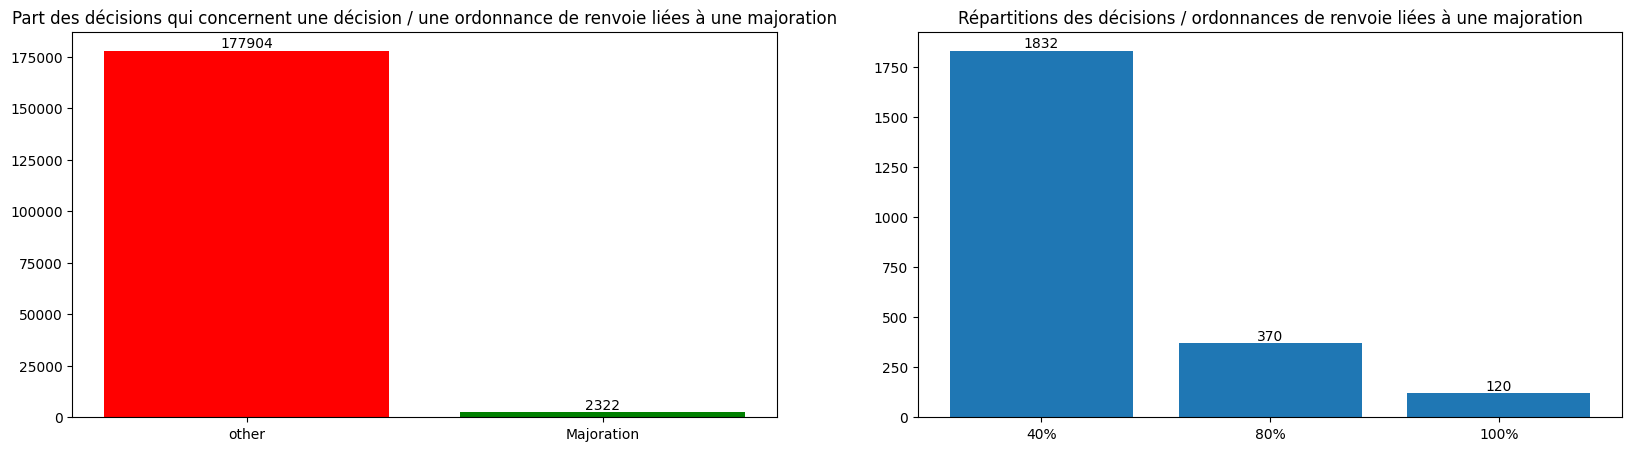

In [47]:
# remove ordonnances de renvoie
df = df[df.ordonnance_de_renvoi == False]

plot, axs = plt.subplots(1, 2, figsize=(20, 5))

# plot 1 : other vs Majoration
nb_1 = df[df.majoration == "other"].shape[0]
nb_2 = df[df.majoration != "other"].shape[0]

axs[0].bar(["other", "Majoration"], [nb_1, nb_2], color=["red", "green"])
axs[0].set_title(
    "Part des décisions qui concernent une décision / une ordonnance de renvoie liées à une majoration"
)

# plot 2 : 40% vs 80% vs 100%
nb_40 = df[df.majoration == "40%"].shape[0]
nb_80 = df[df.majoration == "80%"].shape[0]
nb_100 = df[df.majoration == "100%"].shape[0]

axs[1].bar(["40%", "80%", "100%"], [nb_40, nb_80, nb_100])
axs[1].set_title(
    "Répartitions des décisions / ordonnances de renvoie liées à une majoration"
)

# set the numbers on top of the bars
for i in range(2):
    for bar in axs[i].patches:
        yval = bar.get_height()
        axs[i].text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            round(yval),
            ha="center",
            va="bottom",
        )

plt.show()

# save image
plot.savefig("../output/répartitions_des_majorations.png")